In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, models, transforms
from facenet_pytorch import fixed_image_standardization, MTCNN
from facenet_pytorch import InceptionResnetV1
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
import zipfile
import cv2
from PIL import Image, ImageOps
import gdown
from pillow_heif import register_heif_opener
from tqdm import tqdm
from collections import defaultdict

In [ ]:
url = 'https://drive.google.com/file/d/1tDo2zQC_1ZKY8aMYaalgr6nxRmBcRxaO/view?usp=drive_link'
output_filename = 'downloaded_file.zip'
gdown.download(url, output_filename, quiet=False, fuzzy=True)
print(f"\nDownload selesai! Disimpan sebagai: {output_filename}")

Downloading...
From (original): https://drive.google.com/uc?id=1tDo2zQC_1ZKY8aMYaalgr6nxRmBcRxaO
From (redirected): https://drive.google.com/uc?id=1tDo2zQC_1ZKY8aMYaalgr6nxRmBcRxaO&confirm=t&uuid=af0b6708-27c4-45c7-a3e3-f109855c9c1d
To: /content/downloaded_file.zip
100%|██████████| 428M/428M [00:04<00:00, 90.7MB/s]


Download selesai! Disimpan sebagai: downloaded_file.zip


In [ ]:
zip_path = 'downloaded_file.zip'
extract_path = 'dataset_unzipped'
os.makedirs(extract_path, exist_ok=True)

print(f"Mengekstrak '{zip_path}'...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Ekstraksi selesai.")

Mengekstrak 'downloaded_file.zip'...
Ekstraksi selesai.


In [ ]:
register_heif_opener()

def convert_heic_to_jpg(root_folder, delete_original=True):
    print(f"Mencari file HEIC di:dataset_unzipped/Train...")
    converted_count = 0

    for root, dirs, files in os.walk('dataset_unzipped/Train'):
        for file in files:
            if file.lower().endswith(".heic"):
                heic_path = os.path.join(root, file)

                jpg_path = os.path.splitext(heic_path)[0] + ".jpg"

                try:
                    image = Image.open(heic_path)

                    image = image.convert("RGB")
                    image.save(jpg_path, "JPEG", quality=90)

                    converted_count += 1

                    if delete_original:
                        os.remove(heic_path)

                except Exception as e:
                    print(f"Gagal mengonversi {file}: {e}")

    print(f"\nSelesai! {converted_count} file berhasil dikonversi ke JPG.")

DATASET_DIR = "Train"

convert_heic_to_jpg(DATASET_DIR, delete_original=True)

Mencari file HEIC di:dataset_unzipped/Train...

Selesai! 4 file berhasil dikonversi ke JPG.


In [ ]:
DATASET_DIR = 'dataset_unzipped/Train'

print("Mengonversi WEBP ke JPG...")

for root, dirs, files in os.walk(DATASET_DIR):
    for file in files:
        if file.lower().endswith(".webp"):
            webp_path = os.path.join(root, file)
            jpg_path = os.path.splitext(webp_path)[0] + ".jpg"

            try:
                im = Image.open(webp_path).convert("RGB")
                im.save(jpg_path, "JPEG", quality=95)

                os.remove(webp_path)
                print(f"Converted: {file}")
            except Exception as e:
                print(f"Gagal convert {file}: {e}")

print("Selesai konversi WebP!")

Mengonversi WEBP ke JPG...
Converted: 8d75deaa5e9cb8b38b51b1e7ccddf6fe_1728758888771_0.webp - Raditya Erza Farandi.webp
Converted: 29226d12f5cfbf90a5f75028c8a794ae_1744472103609_0.webp - Raditya Erza Farandi.webp
Converted: IMG_20240320_110842_570 - Alief Fathur Rahman.webp
Converted: temp_image_F4A45BFD-5507-4426-8E53-4E95A2709B45 - NASYA AULIA EFENDI.webp
Converted: temp_image_5BD313DA-028B-4E44-92B4-98405A6C90DA - NASYA AULIA EFENDI.webp
Converted: IMG_20231217_111304_702 - MARTUA KEVIN ANDREAS MUAL H LUBIS.webp
Converted: IMG_20250423_144348_683 - Intan Permata Sari.webp
Converted: IMG_20250801_111220_207 - Intan Permata Sari.webp
Converted: IMG_20240410_112254_085 - Intan Permata Sari.webp
Converted: IMG_20250224_170010_146 - Intan Permata Sari.webp
Selesai konversi WebP!


In [ ]:
SOURCE_DIR = 'dataset_unzipped/Train'
DEST_DIR = 'dataset_unzipped/Data_Cropped'
IMG_SIZE = 160
PADDING_RATIO = 0.20

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Menggunakan device untuk deteksi: {device}")
mtcnn = MTCNN(
    keep_all=True,
    device=device,
    min_face_size=20,
    thresholds=[0.4, 0.5, 0.5],
    margin=0
)

Menggunakan device untuk deteksi: cuda:0


In [ ]:
def crop_face_mtcnn(image_path, padding_ratio=0.2):
    try:
        img = Image.open(image_path).convert('RGB')

        img = ImageOps.exif_transpose(img)

    except Exception:
        return None

    # Deteksi Wajah
    try:
        boxes, probs = mtcnn.detect(img)
    except Exception:
        return None

    if boxes is None:
        return None

    # Cari Wajah Terbaik (Kombinasi Luas Terbesar & Confidence Tinggi)
    best_box = None
    max_score = 0

    for box, prob in zip(boxes, probs):
        x1, y1, x2, y2 = box
        w = x2 - x1
        h = y2 - y1
        area = w * h

        score = area * prob

        if score > max_score:
            max_score = score
            best_box = box

    if best_box is None:
        return None

    # Proses Crop dengan Padding
    x1, y1, x2, y2 = best_box
    w = x2 - x1
    h = y2 - y1

    img_w, img_h = img.size

    pad_x = int(w * padding_ratio)
    pad_y = int(h * padding_ratio)

    # Koordinat baru
    new_x1 = max(0, int(x1 - pad_x))
    new_y1 = max(0, int(y1 - pad_y))
    new_x2 = min(img_w, int(x2 + pad_x))
    new_y2 = min(img_h, int(y2 + pad_y))

    if new_x2 <= new_x1 or new_y2 <= new_y1:
        return None

    # Crop
    cropped_face = img.crop((new_x1, new_y1, new_x2, new_y2))

    return cropped_face

In [ ]:
if not os.path.exists(DEST_DIR):
    os.makedirs(DEST_DIR)

print(f"Memulai proses cropping dengan MTCNN (PyTorch)...")

# Ambil folder kelas
classes = [d for d in os.listdir(SOURCE_DIR) if os.path.isdir(os.path.join(SOURCE_DIR, d))]

for class_name in classes:
    class_path = os.path.join(SOURCE_DIR, class_name)
    dest_class_path = os.path.join(DEST_DIR, class_name)
    os.makedirs(dest_class_path, exist_ok=True)

    # Filter ekstensi gambar
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.webp')
    images = [f for f in os.listdir(class_path) if f.lower().endswith(valid_extensions)]

    print(f"\nMemproses kelas: {class_name} ({len(images)} gambar)...")

    valid_count = 0
    skipped_count = 0

    for img_name in tqdm(images, unit="img"):
        save_path = os.path.join(dest_class_path, img_name)

        # Skip jika sudah ada (Resume capability)
        if os.path.exists(save_path):
            valid_count += 1
            continue

        img_path = os.path.join(class_path, img_name)

        # PANGGIL FUNGSI MTCNN
        cropped_img = crop_face_mtcnn(img_path, padding_ratio=PADDING_RATIO)

        if cropped_img is not None:
            # Resize ke target (160x160 untuk InceptionResnetV1)
            cropped_img = cropped_img.resize((IMG_SIZE, IMG_SIZE), Image.Resampling.LANCZOS)

            # Simpan
            # Pastikan convert RGB sebelum save (jika input ada alpha channel)
            cropped_img.convert('RGB').save(save_path, quality=95)
            valid_count += 1
        else:
            skipped_count += 1

    print(f"  -> Selesai. Disimpan: {valid_count}, Skip: {skipped_count}")

print(f"\nSelesai! Dataset siap di: {DEST_DIR}")

Memulai proses cropping dengan MTCNN (PyTorch)...

Memproses kelas: Bezalel Samuel Manik (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  2.00img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: hayyatul fajri (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  2.56img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Arkan Hariz Chandrawinata Liem (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  6.95img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Fajrul Ramadhana Aqsa (4 gambar)...


100%|██████████| 4/4 [00:00<00:00, 11.95img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Mychael Daniel N (4 gambar)...


100%|██████████| 4/4 [00:02<00:00,  1.49img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Kenneth Austin Wijaya (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  8.92img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Raditya Erza Farandi (4 gambar)...


100%|██████████| 4/4 [00:02<00:00,  1.40img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Zefanya Danovanta Tarigan (4 gambar)...


100%|██████████| 4/4 [00:07<00:00,  1.95s/img]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: JP. Rafi Radiktya Arkan. R. AZ (4 gambar)...


100%|██████████| 4/4 [00:03<00:00,  1.19img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Ferdana Al Hakim (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  2.26img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Dyo Dwi Carol Bukit (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  4.95img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Ikhsannudin Lathief (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  7.09img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Joyapul Hanscalvin Panjaitan (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  3.01img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Fayyadh Abdillah (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  2.78img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Gabriella Natalya Rumapea (4 gambar)...


100%|██████████| 4/4 [00:02<00:00,  1.69img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Joshua Palti Sinaga (8 gambar)...


100%|██████████| 8/8 [00:10<00:00,  1.31s/img]


  -> Selesai. Disimpan: 8, Skip: 0

Memproses kelas: Dwi Arthur Revangga (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  6.86img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Fiqri Aldiansyah (4 gambar)...


100%|██████████| 4/4 [00:02<00:00,  1.70img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Zaky Ahmad Makarim (4 gambar)...


100%|██████████| 4/4 [00:03<00:00,  1.08img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Royfran Roger Valentino (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  6.14img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Desty Ananta Purba (4 gambar)...


100%|██████████| 4/4 [00:03<00:00,  1.02img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Abu Bakar Siddiq Siregar (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  9.87img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Femmy Aprillia Putri (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  2.81img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Bayu Ega Ferdana (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  5.31img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Rahmat Aldi Nasda (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  5.13img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Ichsan Kuntadi Baskara (4 gambar)...


100%|██████████| 4/4 [00:04<00:00,  1.01s/img]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Kevin Naufal Dany (4 gambar)...


100%|██████████| 4/4 [00:02<00:00,  2.00img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Falih Dzakwan Zuhdi (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  5.90img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Randy Hendriyawan (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  3.10img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Joy Daniella V (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  3.19img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Garland Wijaya (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  2.43img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Fathan Andi Kartagama (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  2.04img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Muhammad Nelwan Fakhri  (4 gambar)...


100%|██████████| 4/4 [00:02<00:00,  1.78img/s]


  -> Selesai. Disimpan: 3, Skip: 1

Memproses kelas: Reynaldi Cristian Simamora (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  8.65img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Zakhi algifari (4 gambar)...


100%|██████████| 4/4 [00:03<00:00,  1.00img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Ahmad Faqih Hasani (4 gambar)...


100%|██████████| 4/4 [00:03<00:00,  1.13img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Dimas Azi Rajab Aizar (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  6.75img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Bintang Fikri Fauzan (4 gambar)...


100%|██████████| 4/4 [00:03<00:00,  1.05img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Freddy Harahap (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  6.18img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Alfajar (4 gambar)...


100%|██████████| 4/4 [00:03<00:00,  1.02img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Rayhan Fatih Gunawan (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  2.54img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Festus Mikhael  (4 gambar)...


100%|██████████| 4/4 [00:03<00:00,  1.18img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Eden Wijaya  (4 gambar)...


100%|██████████| 4/4 [00:02<00:00,  1.42img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Havidz Ridho Pratama (4 gambar)...


100%|██████████| 4/4 [00:02<00:00,  1.89img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Dito Rifki Irawan (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  3.13img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Rizky Abdillah  (4 gambar)...


100%|██████████| 4/4 [00:03<00:00,  1.02img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Alief Fathur Rahman (4 gambar)...


100%|██████████| 4/4 [00:08<00:00,  2.04s/img]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Yohanna Anzelika Sitepu  (4 gambar)...


100%|██████████| 4/4 [00:02<00:00,  1.87img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: William Chan (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  9.32img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Joshia Fernandes Sectio Purba  (4 gambar)...


100%|██████████| 4/4 [00:06<00:00,  1.54s/img]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Bayu Prameswara Haris (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  3.96img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Sikah Nubuahtul Ilmi (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  2.33img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Aldi Sanjaya (4 gambar)...


100%|██████████| 4/4 [00:02<00:00,  1.50img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas:  Nasya Aulia Efendi (4 gambar)...


100%|██████████| 4/4 [00:02<00:00,  1.85img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Abraham Ganda Napitu (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  2.05img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Kayla Chika Lathisya  (4 gambar)...


100%|██████████| 4/4 [00:02<00:00,  1.34img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Muhammad Zada Rizki (4 gambar)...


100%|██████████| 4/4 [00:04<00:00,  1.19s/img]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Martua Kevin A.M.H.Lubis (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  4.55img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Rustian Afencius Marbun (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  5.59img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Shintya Ayu Wardani (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  2.68img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Machzaul harmansyah  (4 gambar)...


100%|██████████| 4/4 [00:03<00:00,  1.01img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Boy Sandro Sigiro (4 gambar)...


100%|██████████| 4/4 [00:02<00:00,  1.95img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Muhammad Fasya Atthoriq (4 gambar)...


100%|██████████| 4/4 [00:05<00:00,  1.31s/img]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Lois Novel E Gurning (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  6.91img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Eichal Elphindo Ginting (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  5.45img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Intan Permata Sari  (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  5.25img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Muhammad Riveldo Hermawan Putra (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  4.61img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Elsa Elisa Yohana Sianturi (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  2.65img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Rayhan Fadel Irwanto  (4 gambar)...


100%|██████████| 4/4 [00:05<00:00,  1.43s/img]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Zidan Raihan (4 gambar)...


100%|██████████| 4/4 [00:02<00:00,  1.70img/s]

  -> Selesai. Disimpan: 4, Skip: 0

Selesai! Dataset siap di: dataset_unzipped/Data_Cropped


In [ ]:
def custom_stratified_split(dataset, train_ratio=0.7):
    class_indices = defaultdict(list)

    for idx, label in enumerate(dataset.targets):
        class_indices[label].append(idx)

    train_indices = []
    val_indices = []
    test_indices = []

    classes_warning = []

    print(f"Memproses {len(class_indices)} kelas...")

    for class_id, indices in class_indices.items():
        np.random.shuffle(indices)
        count = len(indices)

        if count >= 3:
            test_indices.append(indices[0])
            val_indices.append(indices[1])
            train_indices.extend(indices[2:])

        elif count == 2:
            test_indices.append(indices[1])
            train_indices.append(indices[0])
            classes_warning.append(dataset.classes[class_id])

        elif count == 1:
            train_indices.append(indices[0])
            classes_warning.append(dataset.classes[class_id])

    # Print Info Statistik
    print(f"\nHasil Split:")
    print(f"Train : {len(train_indices)}")
    print(f"Val   : {len(val_indices)}")
    print(f"Test  : {len(test_indices)}")

    if classes_warning:
        print(f"\nPERINGATAN: {len(classes_warning)} kelas hanya punya 1 gambar (Hanya masuk Train).")

    return (
        Subset(dataset, train_indices),
        Subset(dataset, val_indices),
        Subset(dataset, test_indices)
    )

In [ ]:
data_dir = "dataset_unzipped/Data_Cropped"
full_dataset = datasets.ImageFolder(data_dir)
train_subset, val_subset, test_subset = custom_stratified_split(full_dataset)

print(f"\nHasil Split Manual:")
print(f"Train: {len(train_subset)} gambar")
print(f"Val  : {len(val_subset)} gambar (Dijamin minimal 1 per kelas*)")
print(f"Test : {len(test_subset)} gambar (Dijamin minimal 1 per kelas*)")
print("*kecuali kelas yang jumlah total gambarnya < 3")

Memproses 70 kelas...

Hasil Split:
Train : 143
Val   : 70
Test  : 70

Hasil Split Manual:
Train: 143 gambar
Val  : 70 gambar (Dijamin minimal 1 per kelas*)
Test : 70 gambar (Dijamin minimal 1 per kelas*)
*kecuali kelas yang jumlah total gambarnya < 3


In [ ]:
class ApplyTransform(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [ ]:
IMG_SIZE = 160
face_mean = [0.5, 0.5, 0.5]
face_std  = [0.5, 0.5, 0.5]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.5, 1.0), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(mean=face_mean, std=face_std),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0)
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=face_mean, std=face_std)
])

print("Transforms untuk Validasi/Test (Fixed Standardization):")
print(val_test_transform)
print("\nTransforms untuk Training (Custom Augmentation):")
print(train_transform)

Transforms untuk Validasi/Test (Fixed Standardization):
Compose(
    Resize(size=(160, 160), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

Transforms untuk Training (Custom Augmentation):
Compose(
    RandomResizedCrop(size=(160, 160), scale=(0.5, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    RandomErasing(p=0.2, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
)


In [ ]:
train_dataset = ApplyTransform(train_subset, transform=train_transform)
val_dataset = ApplyTransform(val_subset, transform=val_test_transform)
test_dataset = ApplyTransform(test_subset, transform=val_test_transform)

In [ ]:
BATCH_SIZE  = 8
NUM_EPOCHS = 50
PATIENCE = 8

In [ ]:
NUM_WORKERS = 2
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
class_names = full_dataset.classes
print(class_names)
NUM_CLASSES = len(class_names)

print(f"Memuat model InceptionResnetV1 (Pretrained VGGFace2)...")

model = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes=NUM_CLASSES)

for param in model.parameters():
    param.requires_grad = False

print("Backbone berhasil dibekukan (Frozen).")
print(f"Mendeteksi {NUM_CLASSES} kelas.")

in_features = model.logits.in_features

print(f"Mengganti Head Model (Logits) untuk output {NUM_CLASSES} kelas...")

model.logits = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(512, NUM_CLASSES)
)

model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal Parameter: {total_params:,}")
print(f"Parameter yang Dilatih (Head saja): {trainable_params:,}")
print("Model siap dilatih! (Menggunakan pengetahuan VGGFace2)")

[' Nasya Aulia Efendi', 'Abraham Ganda Napitu', 'Abu Bakar Siddiq Siregar', 'Ahmad Faqih Hasani', 'Aldi Sanjaya', 'Alfajar', 'Alief Fathur Rahman', 'Arkan Hariz Chandrawinata Liem', 'Bayu Ega Ferdana', 'Bayu Prameswara Haris', 'Bezalel Samuel Manik', 'Bintang Fikri Fauzan', 'Boy Sandro Sigiro', 'Desty Ananta Purba', 'Dimas Azi Rajab Aizar', 'Dito Rifki Irawan', 'Dwi Arthur Revangga', 'Dyo Dwi Carol Bukit', 'Eden Wijaya ', 'Eichal Elphindo Ginting', 'Elsa Elisa Yohana Sianturi', 'Fajrul Ramadhana Aqsa', 'Falih Dzakwan Zuhdi', 'Fathan Andi Kartagama', 'Fayyadh Abdillah', 'Femmy Aprillia Putri', 'Ferdana Al Hakim', 'Festus Mikhael ', 'Fiqri Aldiansyah', 'Freddy Harahap', 'Gabriella Natalya Rumapea', 'Garland Wijaya', 'Havidz Ridho Pratama', 'Ichsan Kuntadi Baskara', 'Ikhsannudin Lathief', 'Intan Permata Sari ', 'JP. Rafi Radiktya Arkan. R. AZ', 'Joshia Fernandes Sectio Purba ', 'Joshua Palti Sinaga', 'Joy Daniella V', 'Joyapul Hanscalvin Panjaitan', 'Kayla Chika Lathisya ', 'Kenneth Austi

  0%|          | 0.00/107M [00:00<?, ?B/s]

Backbone berhasil dibekukan (Frozen).
Mendeteksi 70 kelas.
Mengganti Head Model (Logits) untuk output 70 kelas...

Total Parameter: 23,781,190
Parameter yang Dilatih (Head saja): 298,566
Model siap dilatih! (Menggunakan pengetahuan VGGFace2)


In [ ]:
def get_fresh_model(num_classes, device):
    model = InceptionResnetV1(pretrained='vggface2', classify=True)

    for param in model.parameters():
        param.requires_grad = False

    in_features = model.logits.in_features

    model.logits = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(in_features, 512),
        nn.ReLU(),
        nn.Dropout(p=0.4),
        nn.Linear(512, num_classes)
    )

    return model.to(device)

In [ ]:
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,
    weight_decay=1e-2
)

scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

In [ ]:
print(model)

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, patience, device, fold_idx):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    print(f"\n>>> Memulai Training Fold {fold_idx+1} <<<")

    for epoch in range(num_epochs):
        model.train()

        running_train_loss = 0.0
        train_correct = 0
        train_total = 0

        # Gunakan TQDM untuk Training
        train_loop = tqdm(train_loader, desc=f"Fold {fold_idx+1} Epoch {epoch+1} [Train]", leave=False)

        for inputs, labels in train_loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Clip gradient
            torch.nn.utils.clip_grad_norm_(filter(lambda p: p.requires_grad, model.parameters()), max_norm=1.0)

            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

            # Update bar
            train_loop.set_postfix(loss=loss.item())

        avg_train_loss = running_train_loss / len(train_loader.dataset)
        avg_train_acc = 100 * train_correct / train_total

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(avg_train_acc)

        # --- VALIDATION ---
        model.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = running_val_loss / len(val_loader.dataset)
        val_acc = 100 * correct / total

        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)

        scheduler.step()

        current_lr = optimizer.param_groups[0]['lr']
        print(f"   Train Loss: {avg_train_loss:.4f} Acc: {avg_train_acc:.2f}% | Val Loss: {avg_val_loss:.4f} Acc: {val_acc:.2f}% | LR: {current_lr:.2e}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            save_filename = f"best_model_fold_{fold_idx+1}.pth"
            torch.save(model.state_dict(), save_filename)
            print(f"   -> Model Saved to {save_filename}")
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"   Early stopping di Epoch {epoch+1}")
            break

    model.load_state_dict(best_model_wts)
    print(f"Selesai Fold {fold_idx+1}. Best Val Loss: {best_val_loss:.4f}")

    model.eval()
    fold_preds = []
    fold_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            fold_preds.extend(preds.cpu().numpy())
            fold_labels.extend(labels.cpu().numpy())

    return history, fold_preds, fold_labels

In [21]:
K_FOLDS = 4
all_labels = [label for _, label in full_dataset]

# Inisialisasi K-Fold
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

global_true_labels = []
global_pred_labels = []
all_folds_history = []
print(f"Memulai {K_FOLDS}-Fold Cross Validation...")

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(all_labels)), all_labels)):

    # 1. Split Data
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)

    # 2. Terapkan Transform (Train=Augment, Val=Bersih)
    train_fold_dataset = ApplyTransform(train_subset, transform=train_transform)
    val_fold_dataset = ApplyTransform(val_subset, transform=val_test_transform)

    # 3. DataLoader
    train_loader_fold = DataLoader(train_fold_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
    val_loader_fold = DataLoader(val_fold_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # 4. RESET MODEL & OPTIMIZER (Wajib Fresh Instance)
    model_fold = get_fresh_model(num_classes=len(full_dataset.classes), device=device)

    optimizer_fold = optim.AdamW(
        filter(lambda p: p.requires_grad, model_fold.parameters()),
        lr=1e-3,
        weight_decay=1e-2
    )

    scheduler_fold = optim.lr_scheduler.CosineAnnealingLR(optimizer_fold, T_max=NUM_EPOCHS, eta_min=1e-6)
    criterion_fold = nn.CrossEntropyLoss()

    # 5. Jalankan Training Fold Tersebut
    history, fold_preds, fold_labels = train_model(
          model_fold,
          train_loader_fold,
          val_loader_fold,
          criterion_fold,
          optimizer_fold,
          scheduler_fold,
          NUM_EPOCHS,
          PATIENCE,
          device,
          fold
      )

    # Kumpulkan hasil fold ini ke wadah global
    all_folds_history.append(history)
    global_pred_labels.extend(fold_preds)
    global_true_labels.extend(fold_labels)

print("\nCross Validation Selesai.")

Memulai 4-Fold Cross Validation...


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(



>>> Memulai Training Fold 1 <<<


   Train Loss: 4.3137 Acc: 2.40% | Val Loss: 3.4741 Acc: 30.99% | LR: 9.99e-04
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 3.5196 Acc: 21.63% | Val Loss: 2.3352 Acc: 69.01% | LR: 9.96e-04
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 2.8998 Acc: 37.50% | Val Loss: 1.3614 Acc: 91.55% | LR: 9.91e-04
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 2.3957 Acc: 45.67% | Val Loss: 0.8288 Acc: 91.55% | LR: 9.84e-04
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 2.0433 Acc: 57.69% | Val Loss: 0.4868 Acc: 92.96% | LR: 9.76e-04
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.5128 Acc: 64.42% | Val Loss: 0.3187 Acc: 97.18% | LR: 9.65e-04
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.7818 Acc: 59.62% | Val Loss: 0.2063 Acc: 97.18% | LR: 9.52e-04
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.3044 Acc: 72.12% | Val Loss: 0.1556 Acc: 98.59% | LR: 9.38e-04
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.3887 Acc: 67.79% | Val Loss: 0.1441 Acc: 97.18% | LR: 9.22e-04
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.2576 Acc: 70.19% | Val Loss: 0.1171 Acc: 98.59% | LR: 9.05e-04
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.3881 Acc: 67.31% | Val Loss: 0.0940 Acc: 98.59% | LR: 8.85e-04
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.1207 Acc: 74.04% | Val Loss: 0.1009 Acc: 97.18% | LR: 8.65e-04


   Train Loss: 1.3449 Acc: 63.94% | Val Loss: 0.1105 Acc: 97.18% | LR: 8.42e-04


   Train Loss: 1.0471 Acc: 74.52% | Val Loss: 0.0572 Acc: 98.59% | LR: 8.19e-04
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.3356 Acc: 71.15% | Val Loss: 0.0690 Acc: 98.59% | LR: 7.94e-04


   Train Loss: 1.0379 Acc: 78.85% | Val Loss: 0.0695 Acc: 98.59% | LR: 7.68e-04


   Train Loss: 1.1928 Acc: 72.12% | Val Loss: 0.0689 Acc: 98.59% | LR: 7.41e-04


   Train Loss: 1.2486 Acc: 71.63% | Val Loss: 0.0445 Acc: 98.59% | LR: 7.13e-04
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.1529 Acc: 74.04% | Val Loss: 0.0798 Acc: 97.18% | LR: 6.84e-04


   Train Loss: 1.2243 Acc: 70.67% | Val Loss: 0.0641 Acc: 98.59% | LR: 6.55e-04


   Train Loss: 0.9876 Acc: 75.48% | Val Loss: 0.0637 Acc: 98.59% | LR: 6.25e-04


   Train Loss: 1.2384 Acc: 70.67% | Val Loss: 0.0511 Acc: 97.18% | LR: 5.94e-04


   Train Loss: 1.0549 Acc: 71.15% | Val Loss: 0.0431 Acc: 98.59% | LR: 5.63e-04
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.9410 Acc: 75.48% | Val Loss: 0.0369 Acc: 98.59% | LR: 5.32e-04
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.1947 Acc: 72.60% | Val Loss: 0.0570 Acc: 98.59% | LR: 5.00e-04


   Train Loss: 0.8860 Acc: 77.40% | Val Loss: 0.0434 Acc: 98.59% | LR: 4.69e-04


   Train Loss: 1.1793 Acc: 69.71% | Val Loss: 0.0525 Acc: 98.59% | LR: 4.38e-04


   Train Loss: 1.0710 Acc: 75.00% | Val Loss: 0.2102 Acc: 92.96% | LR: 4.07e-04


   Train Loss: 1.0126 Acc: 75.00% | Val Loss: 0.0927 Acc: 94.37% | LR: 3.76e-04


   Train Loss: 1.0914 Acc: 75.48% | Val Loss: 0.0323 Acc: 100.00% | LR: 3.46e-04
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.0814 Acc: 73.56% | Val Loss: 0.0389 Acc: 98.59% | LR: 3.17e-04


   Train Loss: 1.1003 Acc: 76.92% | Val Loss: 0.0397 Acc: 100.00% | LR: 2.88e-04


   Train Loss: 0.9427 Acc: 77.88% | Val Loss: 0.0217 Acc: 100.00% | LR: 2.60e-04
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.4040 Acc: 67.79% | Val Loss: 0.1414 Acc: 95.77% | LR: 2.33e-04


   Train Loss: 0.9156 Acc: 78.37% | Val Loss: 0.0361 Acc: 100.00% | LR: 2.07e-04


   Train Loss: 0.8650 Acc: 78.85% | Val Loss: 0.0633 Acc: 95.77% | LR: 1.82e-04


   Train Loss: 1.2225 Acc: 73.08% | Val Loss: 0.1750 Acc: 94.37% | LR: 1.59e-04


   Train Loss: 0.9760 Acc: 77.40% | Val Loss: 0.0449 Acc: 97.18% | LR: 1.36e-04


   Train Loss: 0.9501 Acc: 78.85% | Val Loss: 0.0341 Acc: 98.59% | LR: 1.16e-04


   Train Loss: 1.0262 Acc: 75.48% | Val Loss: 0.0862 Acc: 97.18% | LR: 9.64e-05


   Train Loss: 0.7664 Acc: 80.77% | Val Loss: 0.0340 Acc: 98.59% | LR: 7.88e-05
   Early stopping di Epoch 41
Selesai Fold 1. Best Val Loss: 0.0217

>>> Memulai Training Fold 2 <<<


   Train Loss: 4.3586 Acc: 1.92% | Val Loss: 3.4761 Acc: 26.76% | LR: 9.99e-04
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 3.5033 Acc: 24.52% | Val Loss: 2.4442 Acc: 66.20% | LR: 9.96e-04
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 2.7601 Acc: 40.38% | Val Loss: 1.4943 Acc: 87.32% | LR: 9.91e-04
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 2.2009 Acc: 50.48% | Val Loss: 0.9182 Acc: 92.96% | LR: 9.84e-04
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.8931 Acc: 59.13% | Val Loss: 0.7267 Acc: 90.14% | LR: 9.76e-04
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.5915 Acc: 63.94% | Val Loss: 0.5391 Acc: 90.14% | LR: 9.65e-04
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.5718 Acc: 65.87% | Val Loss: 0.3476 Acc: 91.55% | LR: 9.52e-04
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.6272 Acc: 64.42% | Val Loss: 0.2774 Acc: 94.37% | LR: 9.38e-04
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.1769 Acc: 72.60% | Val Loss: 0.2511 Acc: 97.18% | LR: 9.22e-04
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.3815 Acc: 65.38% | Val Loss: 0.2658 Acc: 95.77% | LR: 9.05e-04


   Train Loss: 1.1917 Acc: 71.63% | Val Loss: 0.1813 Acc: 97.18% | LR: 8.85e-04
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.2149 Acc: 68.27% | Val Loss: 0.1233 Acc: 97.18% | LR: 8.65e-04
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.3944 Acc: 65.87% | Val Loss: 0.5304 Acc: 88.73% | LR: 8.42e-04


   Train Loss: 1.3761 Acc: 66.35% | Val Loss: 0.3185 Acc: 94.37% | LR: 8.19e-04


   Train Loss: 1.2752 Acc: 68.27% | Val Loss: 0.2245 Acc: 92.96% | LR: 7.94e-04


   Train Loss: 1.0724 Acc: 71.63% | Val Loss: 0.1889 Acc: 94.37% | LR: 7.68e-04


   Train Loss: 1.1462 Acc: 71.15% | Val Loss: 0.1814 Acc: 92.96% | LR: 7.41e-04


   Train Loss: 0.9985 Acc: 74.52% | Val Loss: 0.1842 Acc: 92.96% | LR: 7.13e-04


   Train Loss: 1.0007 Acc: 76.44% | Val Loss: 0.2010 Acc: 94.37% | LR: 6.84e-04


   Train Loss: 1.0543 Acc: 72.60% | Val Loss: 0.2169 Acc: 94.37% | LR: 6.55e-04
   Early stopping di Epoch 20
Selesai Fold 2. Best Val Loss: 0.1233

>>> Memulai Training Fold 3 <<<


   Train Loss: 4.3058 Acc: 0.96% | Val Loss: 3.6040 Acc: 35.21% | LR: 9.99e-04
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 3.5030 Acc: 22.12% | Val Loss: 2.5011 Acc: 70.42% | LR: 9.96e-04
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 2.8180 Acc: 39.42% | Val Loss: 1.7503 Acc: 80.28% | LR: 9.91e-04
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 2.1988 Acc: 52.40% | Val Loss: 1.3111 Acc: 85.92% | LR: 9.84e-04
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 2.1346 Acc: 53.85% | Val Loss: 1.0094 Acc: 87.32% | LR: 9.76e-04
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.6463 Acc: 64.42% | Val Loss: 0.4678 Acc: 92.96% | LR: 9.65e-04
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.6746 Acc: 62.50% | Val Loss: 0.3842 Acc: 91.55% | LR: 9.52e-04
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.4303 Acc: 67.31% | Val Loss: 0.3383 Acc: 91.55% | LR: 9.38e-04
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.4756 Acc: 66.35% | Val Loss: 1.0815 Acc: 84.51% | LR: 9.22e-04


   Train Loss: 1.3002 Acc: 69.23% | Val Loss: 0.2691 Acc: 95.77% | LR: 9.05e-04
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.3136 Acc: 68.75% | Val Loss: 0.2215 Acc: 95.77% | LR: 8.85e-04
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.1955 Acc: 71.63% | Val Loss: 0.2284 Acc: 95.77% | LR: 8.65e-04


   Train Loss: 1.2933 Acc: 70.19% | Val Loss: 0.1987 Acc: 94.37% | LR: 8.42e-04
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.2830 Acc: 71.63% | Val Loss: 0.3093 Acc: 92.96% | LR: 8.19e-04


   Train Loss: 1.0313 Acc: 72.12% | Val Loss: 0.1844 Acc: 95.77% | LR: 7.94e-04
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.0075 Acc: 80.77% | Val Loss: 0.1672 Acc: 95.77% | LR: 7.68e-04
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.1492 Acc: 75.00% | Val Loss: 0.1986 Acc: 95.77% | LR: 7.41e-04


   Train Loss: 1.1472 Acc: 75.00% | Val Loss: 0.2306 Acc: 94.37% | LR: 7.13e-04


   Train Loss: 1.2065 Acc: 71.63% | Val Loss: 0.1753 Acc: 95.77% | LR: 6.84e-04


   Train Loss: 1.1459 Acc: 72.60% | Val Loss: 0.1579 Acc: 97.18% | LR: 6.55e-04
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.1693 Acc: 71.63% | Val Loss: 0.1847 Acc: 97.18% | LR: 6.25e-04


   Train Loss: 0.9018 Acc: 78.85% | Val Loss: 0.1816 Acc: 95.77% | LR: 5.94e-04


   Train Loss: 1.3792 Acc: 65.38% | Val Loss: 0.2023 Acc: 95.77% | LR: 5.63e-04


   Train Loss: 1.0203 Acc: 72.60% | Val Loss: 0.1877 Acc: 94.37% | LR: 5.32e-04


   Train Loss: 1.2781 Acc: 68.75% | Val Loss: 0.1711 Acc: 95.77% | LR: 5.00e-04


   Train Loss: 1.0177 Acc: 76.92% | Val Loss: 0.1821 Acc: 95.77% | LR: 4.69e-04


   Train Loss: 1.1604 Acc: 72.12% | Val Loss: 0.1616 Acc: 95.77% | LR: 4.38e-04


   Train Loss: 0.8301 Acc: 79.33% | Val Loss: 0.1638 Acc: 95.77% | LR: 4.07e-04
   Early stopping di Epoch 28
Selesai Fold 3. Best Val Loss: 0.1579

>>> Memulai Training Fold 4 <<<


   Train Loss: 4.2093 Acc: 2.88% | Val Loss: 3.5525 Acc: 35.71% | LR: 9.99e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 3.5285 Acc: 19.23% | Val Loss: 2.5511 Acc: 67.14% | LR: 9.96e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 2.7752 Acc: 37.50% | Val Loss: 1.6123 Acc: 82.86% | LR: 9.91e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 2.0744 Acc: 52.88% | Val Loss: 0.9621 Acc: 91.43% | LR: 9.84e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 1.7701 Acc: 69.23% | Val Loss: 0.6481 Acc: 92.86% | LR: 9.76e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 1.5186 Acc: 70.19% | Val Loss: 0.4742 Acc: 92.86% | LR: 9.65e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 1.2457 Acc: 71.15% | Val Loss: 0.3700 Acc: 95.71% | LR: 9.52e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 1.5040 Acc: 65.87% | Val Loss: 0.5392 Acc: 92.86% | LR: 9.38e-04


   Train Loss: 1.3192 Acc: 67.31% | Val Loss: 0.3396 Acc: 92.86% | LR: 9.22e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 1.1094 Acc: 73.08% | Val Loss: 0.2980 Acc: 94.29% | LR: 9.05e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 1.2022 Acc: 68.75% | Val Loss: 0.2744 Acc: 95.71% | LR: 8.85e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 1.1942 Acc: 71.15% | Val Loss: 0.2523 Acc: 95.71% | LR: 8.65e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 0.9174 Acc: 76.92% | Val Loss: 0.2429 Acc: 95.71% | LR: 8.42e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 0.9791 Acc: 74.04% | Val Loss: 0.2366 Acc: 95.71% | LR: 8.19e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 1.1396 Acc: 71.63% | Val Loss: 0.2584 Acc: 95.71% | LR: 7.94e-04


   Train Loss: 1.4382 Acc: 66.83% | Val Loss: 0.3591 Acc: 91.43% | LR: 7.68e-04


   Train Loss: 1.0684 Acc: 71.15% | Val Loss: 0.2694 Acc: 95.71% | LR: 7.41e-04


   Train Loss: 1.3062 Acc: 67.31% | Val Loss: 0.2907 Acc: 94.29% | LR: 7.13e-04


   Train Loss: 0.9766 Acc: 75.00% | Val Loss: 0.3056 Acc: 92.86% | LR: 6.84e-04


   Train Loss: 1.0668 Acc: 75.00% | Val Loss: 0.2354 Acc: 95.71% | LR: 6.55e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 1.2162 Acc: 70.19% | Val Loss: 0.3154 Acc: 91.43% | LR: 6.25e-04


   Train Loss: 1.0246 Acc: 74.04% | Val Loss: 0.3016 Acc: 91.43% | LR: 5.94e-04


   Train Loss: 1.2296 Acc: 71.63% | Val Loss: 0.2216 Acc: 95.71% | LR: 5.63e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 0.9774 Acc: 76.92% | Val Loss: 0.2145 Acc: 95.71% | LR: 5.32e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 0.8104 Acc: 80.77% | Val Loss: 0.2310 Acc: 95.71% | LR: 5.00e-04


   Train Loss: 1.1128 Acc: 73.08% | Val Loss: 0.2300 Acc: 95.71% | LR: 4.69e-04


   Train Loss: 1.1286 Acc: 72.12% | Val Loss: 0.2299 Acc: 94.29% | LR: 4.38e-04


   Train Loss: 0.8144 Acc: 80.77% | Val Loss: 0.2188 Acc: 95.71% | LR: 4.07e-04


   Train Loss: 0.9225 Acc: 76.44% | Val Loss: 0.2099 Acc: 95.71% | LR: 3.76e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 0.7901 Acc: 81.25% | Val Loss: 0.2023 Acc: 95.71% | LR: 3.46e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 1.3073 Acc: 70.19% | Val Loss: 0.2978 Acc: 94.29% | LR: 3.17e-04


   Train Loss: 0.9580 Acc: 78.85% | Val Loss: 0.2168 Acc: 95.71% | LR: 2.88e-04


   Train Loss: 1.0965 Acc: 74.52% | Val Loss: 0.2090 Acc: 95.71% | LR: 2.60e-04


   Train Loss: 0.8711 Acc: 77.88% | Val Loss: 0.2071 Acc: 95.71% | LR: 2.33e-04


   Train Loss: 1.1782 Acc: 71.63% | Val Loss: 0.2342 Acc: 94.29% | LR: 2.07e-04


   Train Loss: 0.9179 Acc: 76.44% | Val Loss: 0.2275 Acc: 94.29% | LR: 1.82e-04


   Train Loss: 0.5945 Acc: 86.54% | Val Loss: 0.1979 Acc: 95.71% | LR: 1.59e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 1.1272 Acc: 72.60% | Val Loss: 0.2138 Acc: 95.71% | LR: 1.36e-04


   Train Loss: 0.9943 Acc: 75.00% | Val Loss: 0.2102 Acc: 95.71% | LR: 1.16e-04


   Train Loss: 1.0852 Acc: 74.52% | Val Loss: 0.2379 Acc: 94.29% | LR: 9.64e-05


   Train Loss: 1.0567 Acc: 75.00% | Val Loss: 0.2006 Acc: 95.71% | LR: 7.88e-05


   Train Loss: 0.9195 Acc: 77.40% | Val Loss: 0.2060 Acc: 95.71% | LR: 6.28e-05


   Train Loss: 0.9604 Acc: 75.48% | Val Loss: 0.2026 Acc: 95.71% | LR: 4.85e-05


   Train Loss: 1.1226 Acc: 74.52% | Val Loss: 0.2156 Acc: 95.71% | LR: 3.61e-05


   Train Loss: 0.8422 Acc: 80.77% | Val Loss: 0.1949 Acc: 95.71% | LR: 2.54e-05
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 1.1542 Acc: 73.08% | Val Loss: 0.2081 Acc: 95.71% | LR: 1.67e-05


   Train Loss: 0.8758 Acc: 80.77% | Val Loss: 0.2207 Acc: 95.71% | LR: 9.85e-06


   Train Loss: 0.8961 Acc: 77.88% | Val Loss: 0.1904 Acc: 95.71% | LR: 4.94e-06
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 1.2398 Acc: 68.75% | Val Loss: 0.2132 Acc: 95.71% | LR: 1.99e-06


   Train Loss: 1.1341 Acc: 72.12% | Val Loss: 0.2031 Acc: 95.71% | LR: 1.00e-06
Selesai Fold 4. Best Val Loss: 0.1904

Cross Validation Selesai.


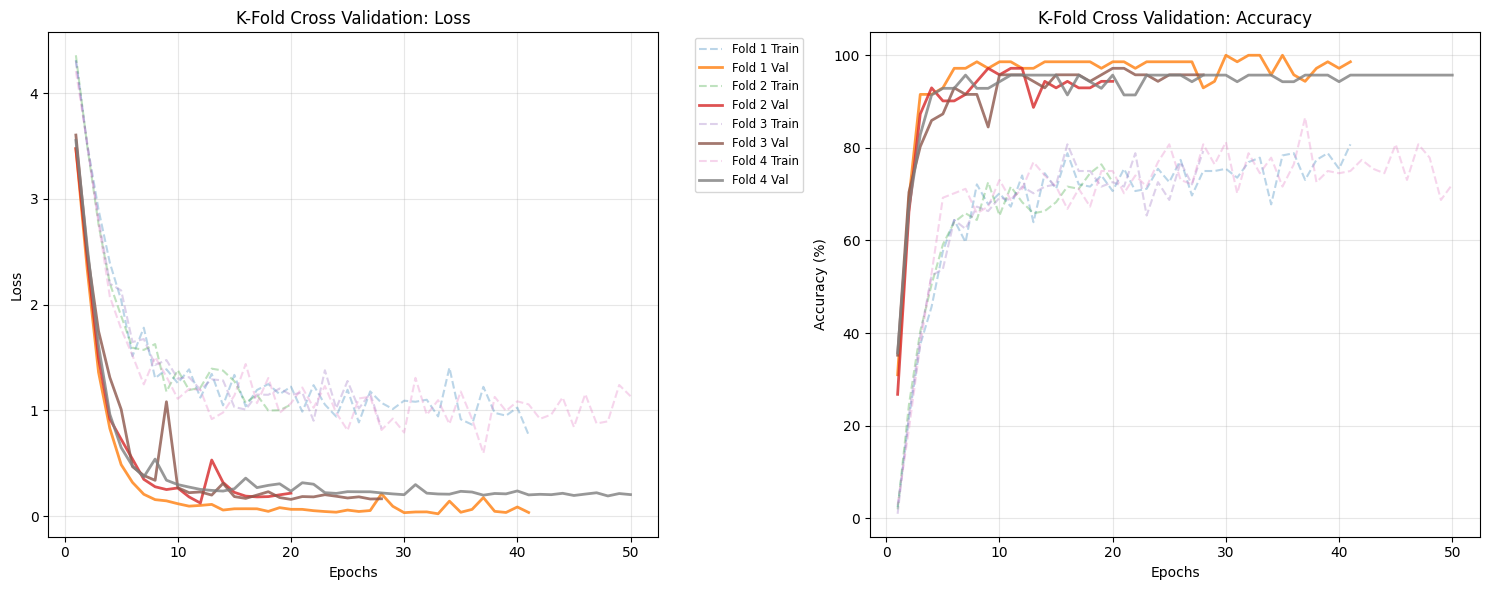

In [22]:
def plot_kfold_history(all_histories):
    plt.figure(figsize=(15, 6))

    # --- PLOT 1: LOSS ---
    plt.subplot(1, 2, 1)
    for i, h in enumerate(all_histories):
        epochs = range(1, len(h['train_loss']) + 1)
        # Plot garis tipis untuk setiap fold
        plt.plot(epochs, h['train_loss'], alpha=0.3, linestyle='--', label=f'Fold {i+1} Train')
        plt.plot(epochs, h['val_loss'], alpha=0.8, linewidth=2, label=f'Fold {i+1} Val')

    plt.title('K-Fold Cross Validation: Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

    # --- PLOT 2: ACCURACY ---
    plt.subplot(1, 2, 2)
    for i, h in enumerate(all_histories):
        epochs = range(1, len(h['train_acc']) + 1)
        # Plot garis tipis untuk setiap fold
        plt.plot(epochs, h['train_acc'], alpha=0.3, linestyle='--', label=f'Fold {i+1} Train')
        plt.plot(epochs, h['val_acc'], alpha=0.8, linewidth=2, label=f'Fold {i+1} Val')

    plt.title('K-Fold Cross Validation: Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.grid(True, alpha=0.3)
    # plt.legend() # Legend dimatikan di kanan agar tidak penuh

    plt.tight_layout()
    plt.show()

# Jalankan plotting
plot_kfold_history(all_folds_history)

In [23]:
print("\n=== AGGREGATED CLASSIFICATION REPORT (Semua Folds) ===")

# Gunakan np.arange agar tidak error jika ada kelas yang hilang
all_indices = np.arange(len(class_names))

print(classification_report(
    global_true_labels,
    global_pred_labels,
    labels=all_indices,
    target_names=class_names,
    zero_division=0
))


=== AGGREGATED CLASSIFICATION REPORT (Semua Folds) ===
                                 precision    recall  f1-score   support

             Nasya Aulia Efendi       0.75      0.75      0.75         4
           Abraham Ganda Napitu       1.00      1.00      1.00         4
       Abu Bakar Siddiq Siregar       1.00      1.00      1.00         4
             Ahmad Faqih Hasani       1.00      1.00      1.00         4
                   Aldi Sanjaya       1.00      1.00      1.00         4
                        Alfajar       1.00      1.00      1.00         4
            Alief Fathur Rahman       1.00      1.00      1.00         4
 Arkan Hariz Chandrawinata Liem       1.00      1.00      1.00         4
               Bayu Ega Ferdana       1.00      1.00      1.00         4
          Bayu Prameswara Haris       1.00      1.00      1.00         4
           Bezalel Samuel Manik       1.00      1.00      1.00         4
           Bintang Fikri Fauzan       1.00      1.00      1.00     


=== AGGREGATED CONFUSION MATRIX ===


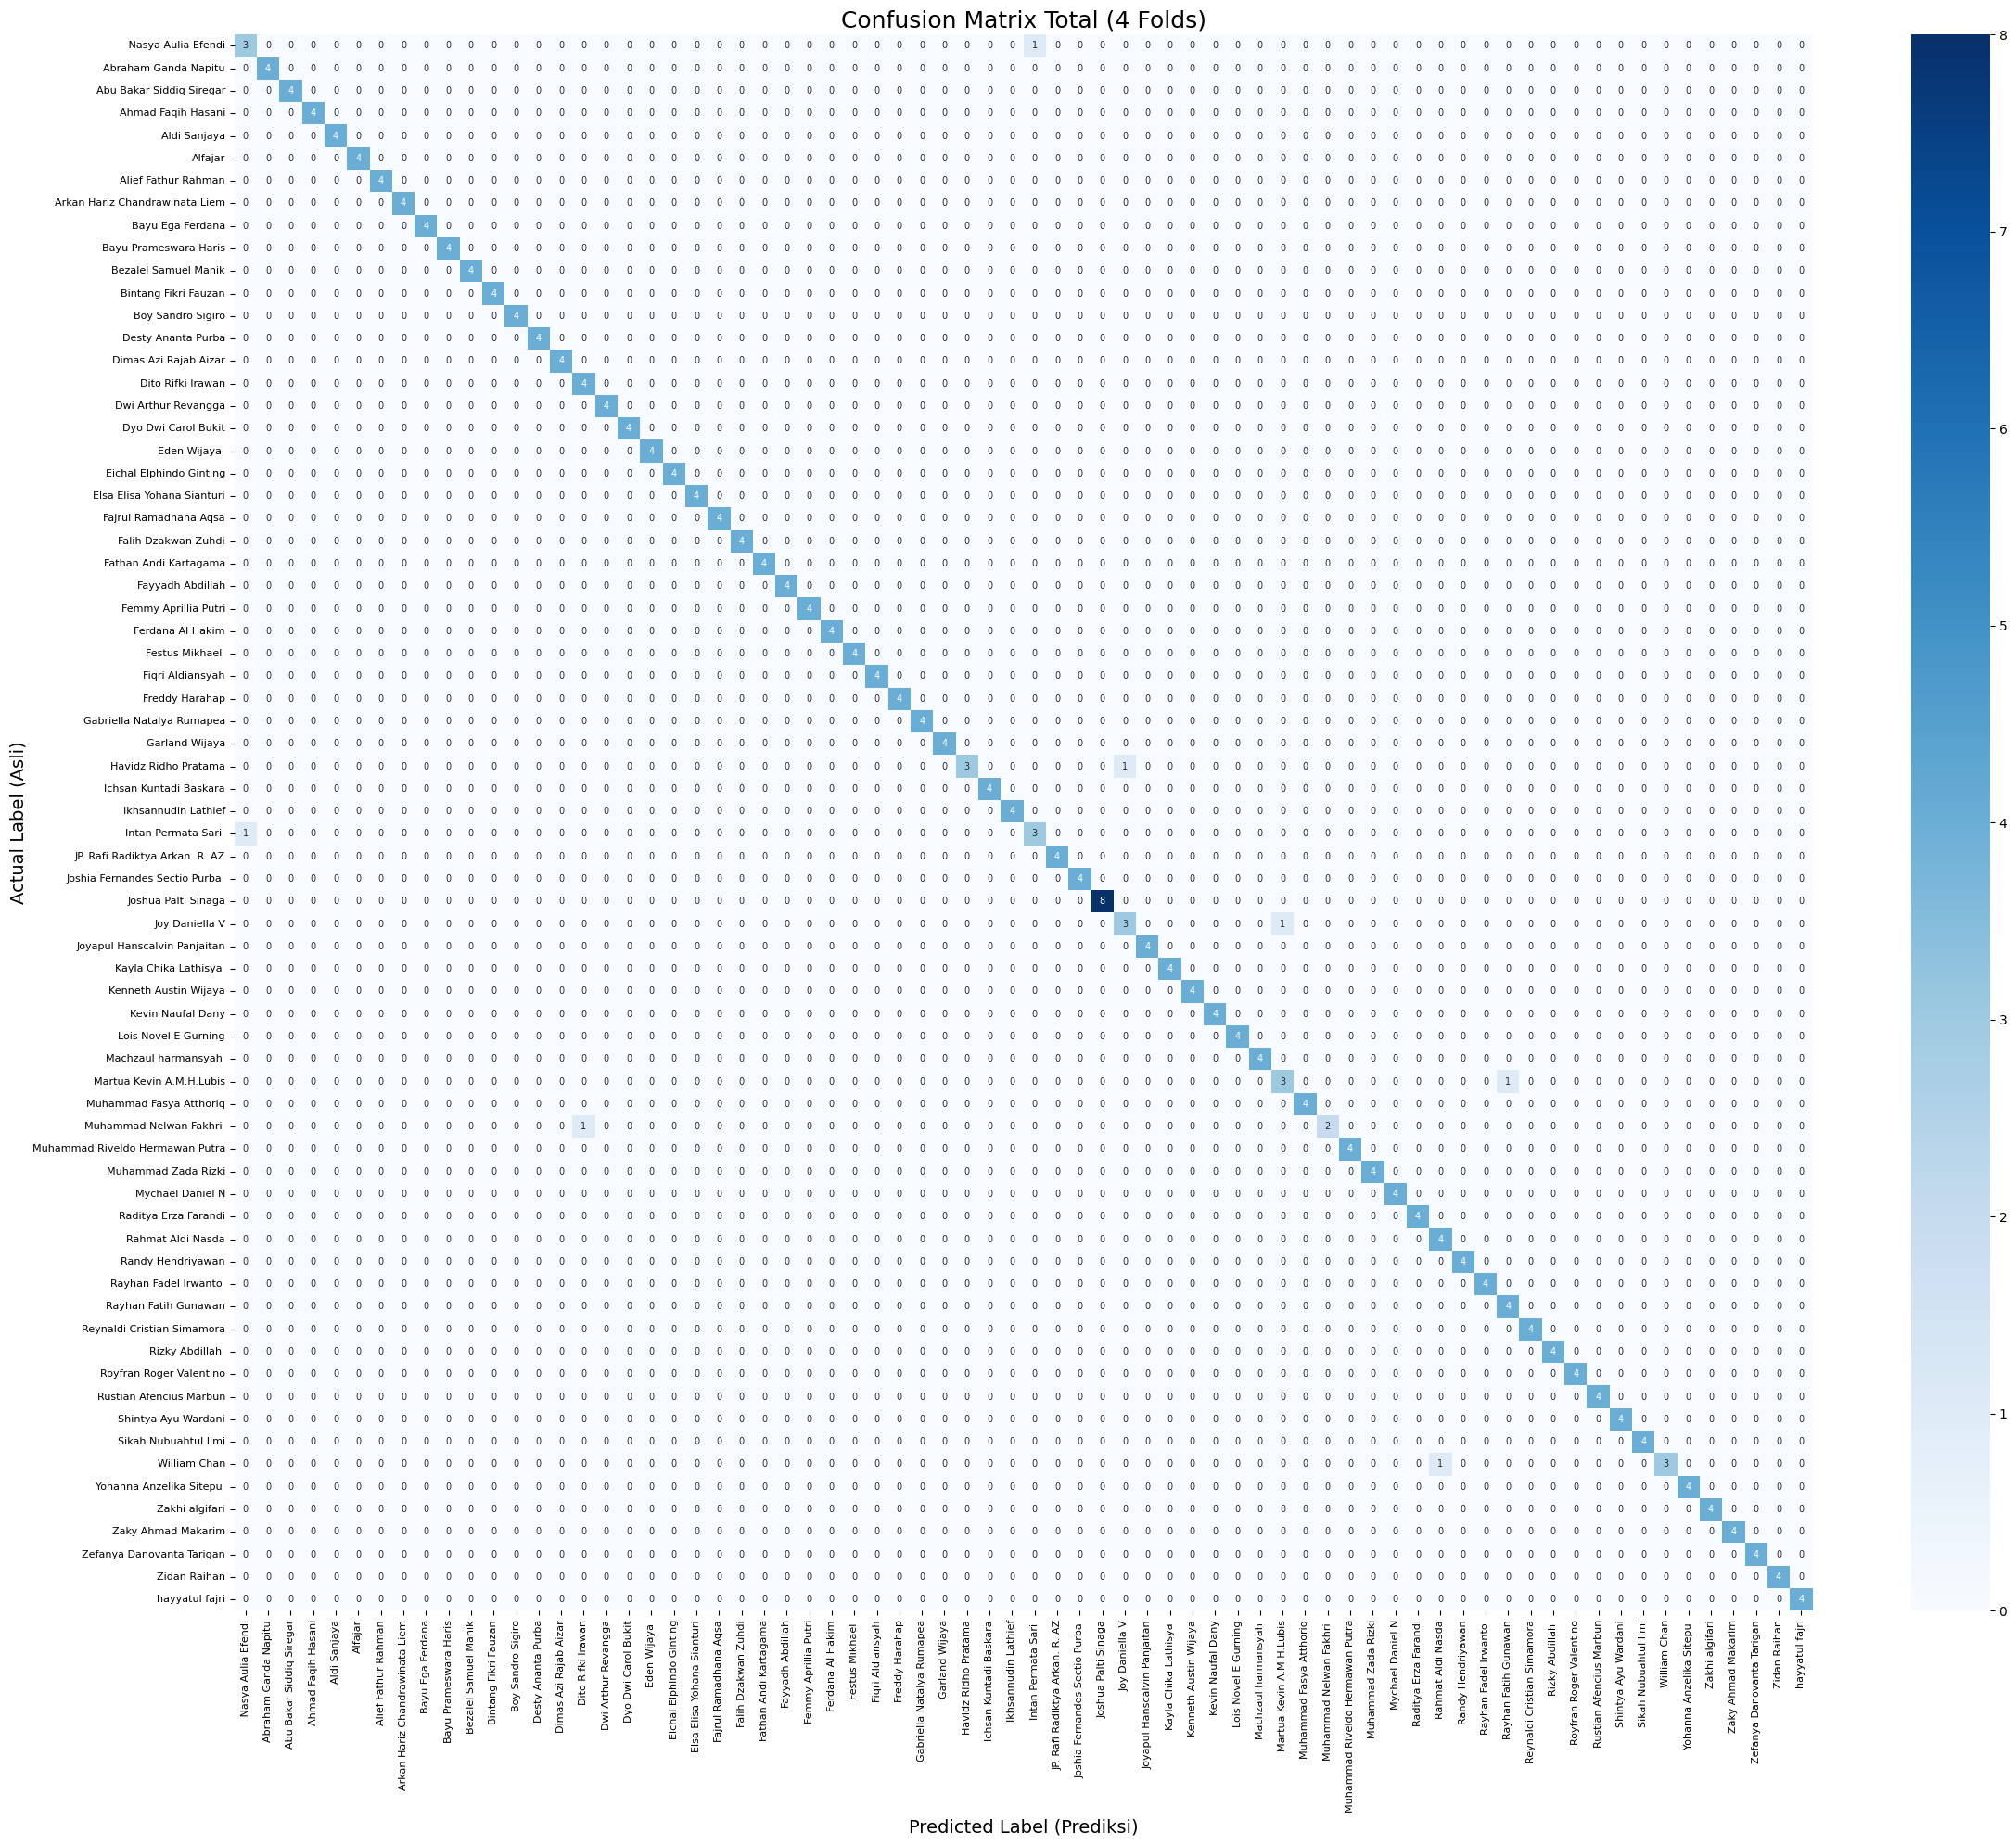

In [24]:
print("\n=== AGGREGATED CONFUSION MATRIX ===")

cm = confusion_matrix(global_true_labels, global_pred_labels, labels=all_indices)

# Karena 70 kelas, kita buat plot yang SANGAT BESAR
plt.figure(figsize=(24, 20)) # Ukuran kanvas besar

sns.heatmap(
    cm,
    annot=True,           # Tampilkan angka
    fmt='d',              # Format angka bulat
    cmap='Blues',         # Warna biru
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={"size": 7} # Perkecil ukuran font angka agar muat
)

plt.ylabel('Actual Label (Asli)', fontsize=14)
plt.xlabel('Predicted Label (Prediksi)', fontsize=14)
plt.title(f'Confusion Matrix Total ({K_FOLDS} Folds)', fontsize=18)
plt.xticks(rotation=90, fontsize=8) # Putar label nama agar terbaca
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()